In [ ]:
!pip install segmentation_models
!pip install albumentations==1.1
!pip install -U opencv-python-headless==4.1.2.30

     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.7 MB 2.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


In [ ]:
import numpy as np
import cv2
import glob
import os
import sys
import matplotlib.pyplot as plt

import tensorflow as tf
import albumentations as A
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
sys.path.insert(0, "/content/drive/MyDrive/CarSegmentation")

In [ ]:
cd /content/drive/MyDrive/CarSegmentation

/content/drive/MyDrive/CarSegmentation


In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, files_list, shuffle=True, mode='train', batch_size=32):
    self.files_list = files_list
    self.shuffle = shuffle
    self.mode = mode
    self.batch_size = batch_size
    self.indexes = np.arange(len(self.files_list))
    self.__augment_data()
    self.on_epoch_end()

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(len(self.files_list)/self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    batch_list = [self.files_list[k] for k in indexes]
    image, mask = self.__data_generation(batch_list)
    return image, mask

  def __data_generation(self, file_list):
    X = []
    Y = []
    for file_name in file_list:
      file_name = os.path.basename(file_name)
      image = cv2.imread(os.path.join(DATA_DIR, "images", file_name))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224,224))

      mask = cv2.imread(os.path.join(DATA_DIR, "masks", file_name), 0)
      mask = cv2.resize(mask, (224,224))
      mask = np.where(mask > 0, 1, 0)

      if self.mode == 'train':
        transformed = self.transform(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

      image = image.astype('float')
      image = image/255.

      X.append(image)
      Y.append(mask)

    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)

    return X, Y

  def __augment_data(self):
    transforms = [
                  A.Flip(p=0.5),
                  A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.5, rotate_limit=45),
                  A.RandomCrop(height=224,width=224,p=0.5),
                  A.RandomRotate90(),
                  A.ColorJitter(),
                  A.ToGray(),
                  A.Blur(),
                  A.RandomSunFlare()
    ]
    self.transform = A.Compose(transforms)


In [ ]:
model = sm.Unet(backbone_name='vgg16', input_shape=(224,224,3), classes=1, activation='sigmoid')
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss = sm.losses.binary_focal_dice_loss,
    metrics=[
             sm.metrics.IOUScore(threshold=0.5), 
             sm.metrics.FScore(threshold=0.5)
             ]
              )
model.summary()

58900480/58889256 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

In [ ]:
DATA_DIR = './data'
files_list = glob.glob(os.path.join(DATA_DIR, "images", "*.png"))
np.random.shuffle(files_list)
num_train = int(0.8 * len(files_list))
train_files_list = files_list[:num_train]
val_files_list = files_list[num_train:]

train_datagen = DataGenerator(train_files_list, shuffle=True, mode='train', batch_size=32)
val_datagen = DataGenerator(val_files_list, shuffle=False, mode='val', batch_size=1)

In [ ]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_iou_score', save_best_only=True, mode='max'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', mode='max', factor=0.5, patience=10),
             tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', mode='max', patience=20, restore_best_weights=True)
]

history = model.fit(
    train_datagen,
    epochs = 100,
    callbacks = callbacks,
    validation_data = val_datagen
)

Epoch 1/100
5/5 [==============================] - 22s 4s/step - loss: 0.7001 - iou_score: 0.3398 - f1-score: 0.5071 - val_loss: 0.8391 - val_iou_score: 0.3656 - val_f1-score: 0.5217 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 21s 5s/step - loss: 0.6522 - iou_score: 0.3672 - f1-score: 0.5370 - val_loss: 0.9454 - val_iou_score: 0.3762 - val_f1-score: 0.5326 - lr: 1.0000e-04
Epoch 3/100
5/5 [==============================] - 18s 4s/step - loss: 0.6178 - iou_score: 0.3893 - f1-score: 0.5604 - val_loss: 1.1432 - val_iou_score: 0.3740 - val_f1-score: 0.5304 - lr: 1.0000e-04
Epoch 4/100
5/5 [==============================] - 16s 3s/step - loss: 0.5844 - iou_score: 0.4121 - f1-score: 0.5834 - val_loss: 1.1725 - val_iou_score: 0.3731 - val_f1-score: 0.5294 - lr: 1.0000e-04
Epoch 5/100
5/5 [==============================] - 16s 3s/step - loss: 0.5543 - iou_score: 0.4207 - f1-score: 0.5919 - val_loss: 1.2017 - val_iou_score: 0.3726 - val_f1-score: 0.5289 - lr: 1.0000e-04


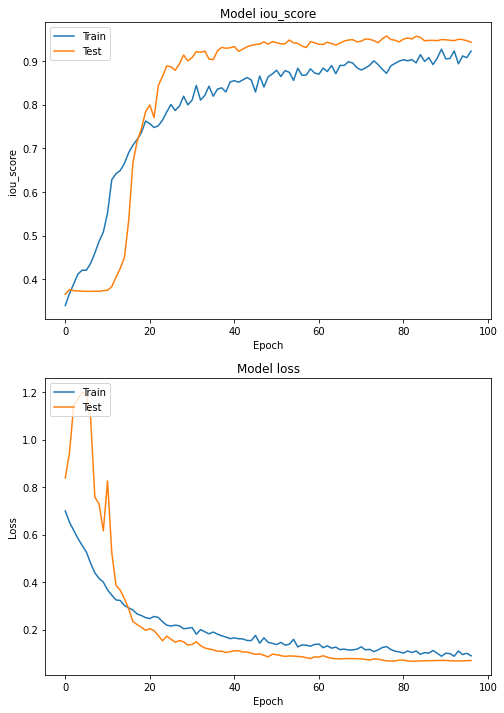

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('./learning_curve.jpg')

In [ ]:
model = tf.keras.models.load_model('./best_model.h5', custom_objects={'binary_focal_loss_plus_dice_loss':sm.losses.binary_focal_dice_loss,'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [ ]:
from time import time

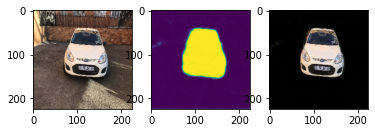

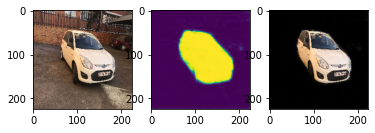

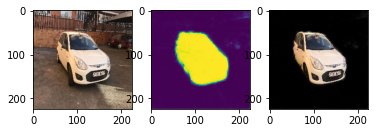

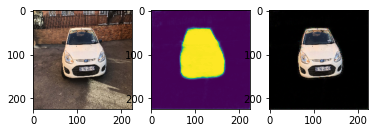

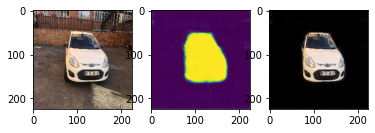

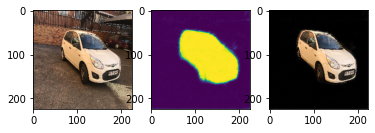

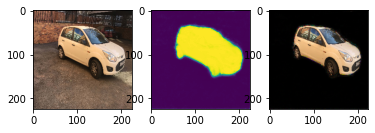

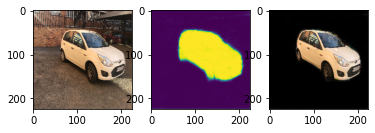

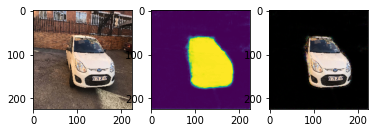

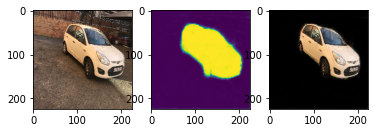

In [ ]:
test_images = glob.glob(os.path.join(DATA_DIR, "Testimages","*.jpeg"))
for img_file in test_images:
  img = cv2.imread(img_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  plt.figure()
  plt.subplot(131)
  plt.imshow(img)
  img = img.astype('float')
  img = img/255.
  img = img[None,:,:,:]
  pred_mask = model.predict(img)[0]
  plt.subplot(132)
  plt.imshow(pred_mask.squeeze(axis=-1))
  mask = cv2.merge([np.array(pred_mask*255.0, dtype=np.uint8), np.array(pred_mask*255.0, dtype=np.uint8), np.array(pred_mask*255.0, dtype=np.uint8)])
  masked = cv2.bitwise_and(np.array(img[0]*255.0, dtype=np.uint8), mask)
  plt.subplot(133)
  plt.imshow(masked)
  plt.show()
  cv2.imwrite(img_file.split('.jpeg')[0]+"_mask.jpeg", mask)
  cv2.imwrite(img_file.split('.jpeg')[0]+"_masked.jpeg", masked[:,:,::-1])